In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import fsps
from scipy import integrate
from scipy.stats import norm
import corner
import emcee

matplotlib.rcParams.update({'font.size': 18})

# Method:

1. Generate a stellar population with imf_type=2 (Kroupa 2001 IMF), zmet=10 (Solar metallicity for MIST Isochrones) and sfh=1-- a five parameter star formation history with const=1 for all the stars being formed in the constant star formation history period.<br />

2. Get the magnitude of the population through the Galex FUV filter today. Convert this magnitude into a flux and then into a luminosity using: <br /><br />
$$m = -2.5\log_{10}{f} - m_0$$ <br />
$$f = 10^{-(m+m_0)/2.5}$$ <br />
$$L = 4\pi D^2 f$$ <br /> 
where $D= 10pc$.<br />
3. You can get the SFR of the stellar population from python fsps.<br />

4. From this you can compute the proportionality constant 'C' using: $$ SFR = \frac{\nu L_{\nu}}{C_{FUV}}$$

In [2]:
csp = fsps.StellarPopulation(imf_type=2,zmet=10,sfh=1,const=1)
mag = csp.get_mags(bands=fsps.find_filter('galex_fuv'),tage=13.7)

mab0 = -2.5*np.log10(3631e-23)
fx = 10**-((mag+mab0)/2.5)
Lx = fx*4*np.pi*(10*3.086e18)**2

fil = fsps.get_filter('galex_fuv')
nu_eff = 2.9979e18/fil.lambda_eff

Cfuv = nu_eff*Lx/csp.sfr

print ("The C_FUV from magnitude calculations is %.2f"%np.log10(Cfuv))

The C_FUV from magnitude calculations is 43.34


### Method 2- Just for documentation:

Initially, not having realised that Kennicutt-92 paper uses $\nu L_{\nu}$, I tried computing the luminosity using the spectrum output by fsps and multiplying it with the normalized Galex FUV filter. I have included that method also here for my own reference later.

In [3]:
c = 2.9979e18 #AA/s
L_sun = 3.846e33 #erg/s

fil = fsps.get_filter('galex_fuv')
fwl, ftrans = fil.transmission
ftrans_norm = ftrans/(integrate.trapz(ftrans,fwl))

wl,spec = csp.get_spectrum(peraa=True,tage=13.7)
mask = np.where((wl>fwl.min())&(wl<fwl.max()))
wl = wl[mask]; spec =spec[mask]

# Trim both the arrays to pick the nearest values- did this by eye
# like a computer inefficient idiot :-/ This trimming results in only
# 3 values being off.

fwl = fwl[5::10] #50 values long
ftrans_norm = ftrans_norm[5::10]

wl = np.delete(wl,[13,20,37])
spec = np.delete(spec,[13,20,37])

L = L_sun*integrate.trapz(wl*spec*ftrans_norm,wl)
C_FUV = L/(csp.sfr)

print ("The C_FUV from spectral luminosity is %.2f"%np.log10(C_FUV))

The C_FUV from spectral luminosity is 43.35


# $C_{FUV} = 43.35$

This value is alarmingly close to Kennicutt & Evans (2012) estimate! Has the oft cited and used relation been derived for a constant star formation history without any dust correction? I ran the above code (magnitude method) with dust correction to see if the constant changes significantly- but it does not.

In [4]:
csp = fsps.StellarPopulation(imf_type=2,zmet=10,sfh=1,const=1,dust_type=2)#Calzetti law
mag = csp.get_mags(bands=fsps.find_filter('galex_fuv'),tage=13.7)

mab0 = -2.5*np.log10(3631e-23)
fx = 10**-((mag+mab0)/2.5)
Lx = fx*4*np.pi*(10*3.086e18)**2

fil = fsps.get_filter('galex_fuv')
nu_eff = 2.9979e18/fil.lambda_eff

Cfuv = nu_eff*Lx/csp.sfr

print ("The C_FUV for a Calzetti law dust correction is %.2f"%np.log10(Cfuv))

The C_FUV for a Calzetti law dust correction is 43.34


# Stellar Mass from B-band Magnitude

To find a scaling relation between the B-band luminosity and stellar mass, I used python-fsps to find the luminosity of a $1M_{\odot}$ galaxy today. If the relation is a straight line, we can expect it to pass through zero and get a slope from the single data point.

In [5]:
csp = fsps.StellarPopulation(imf_type=2,zmet=10,sfh=1,const=1)
mag = csp.get_mags(bands='b',tage=13.7)

mab0 = -2.5*np.log10(3631e-23)
fx = 10**-((mag+mab0)/2.5)
Lx = fx*4*np.pi*(10*3.086e18)**2

C = 1/Lx

bmag = np.linspace(-4,10,num=100)
flux = 10**-((bmag+mab0)/2.5)
Lumin = flux*4*np.pi*(10*3.086e18)**2
mass = C*Lumin

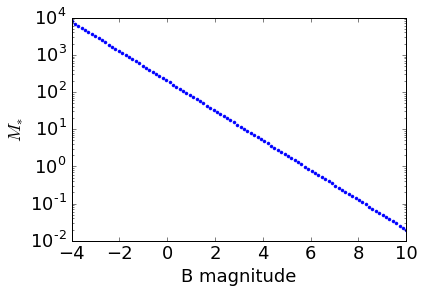

In [6]:
fig,ax = plt.subplots(1,1)
ax.semilogy(bmag,mass,'.')
ax.set_xlabel(r'B magnitude')
ax.set_ylabel(r'$M_{*}$')

This is not a great proxy for a galaxy's stellar mass because the star formation history changes the B-band magnitude. Two galaxies with different star formation histories have different B-band magnitudes even if the mass is the same for both galaxies.

In [7]:
print ('The B-band magnitude for a constant SFH is %f'%csp.get_mags(bands='b',tage=13.7))

expcsp = fsps.StellarPopulation(imf_type=2,zmet=10,sfh=1,tau=0.5)
print ('The B-band magnitude for an exponentially declining SFH with tau=0.1 is %f'
       %expcsp.get_mags(bands='b',tage=13.7))

burst = fsps.StellarPopulation(imf_type=2,zmet=10,sfh=1,fburst=1,tburst=3)
print ('The B-band magnitude for a burst of star formation at 3Gyr is %f'
       %burst.get_mags(bands='b',tage=13.7))

The B-band magnitude for a constant SFH is 5.744351
The B-band magnitude for an exponentially declining SFH with tau=0.1 is 7.916512
The B-band magnitude for a burst of star formation at 3Gyr is 7.698136


# Metallicity from B-band Magnitude

Berg et al (2012) gives the relation between metallicity and the B-band magnitude as:

$$12+\log{O/H}= (6.27\pm 0.21) + (-0.11\pm 0.01)M_{B} $$

with an intrinsic scatter in the relationship of $\sigma = 0.15$. I used this relation to compute the metallicities for all the galaxies in the sample provided.

The total error on the estimated metallicity can be obtained from the errors on slope and intercept (a section below explains propagation of errors in more detail).

$$\sigma_Z = \left((0.21)^2 + \left[\left(\left(\frac{0.01}{0.11}\right)^2+\left(\frac{\sigma_{M_b}}{M_b}\right)^2\right)(0.11M_b)^2\right]\right) $$

Over and above this intrinsic error, I added a scatter drawn from a gaussian of $\sigma = 0.15$.

In [8]:
dist,bmag = np.loadtxt('ps5.data',comments='#',usecols=(7,8)).T
# add 0.1mag uncertainities to the b-magnitudes
M = bmag+5-5*np.log10(dist*1e6)
Merr = np.random.normal(loc=0,scale=0.1,size=np.size(dist))
Mb = M+Merr

# Z = np.random.normal(loc=6.27,scale=0.21,size=np.size(dist))
# +(np.random.normal(loc=-0.11,scale=0.01,size=np.size(dist)))*Mb
# Zerr = np.random.normal(loc=0,scale=0.15,size=np.size(dist))
# Zf = Z+Zerr

Z = 6.27+(-0.11)*M
Zerr = np.sqrt((0.21)**2 + ((0.01/0.11)**2+(Merr/M)**2)*(0.11*M)**2)
+np.random.normal(loc=0,scale=0.15,size=np.size(dist))
Zf= Z+Zerr

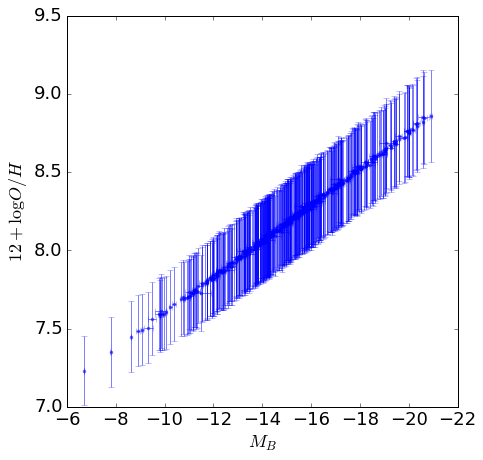

In [9]:
fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.errorbar(Mb,Zf,xerr=Merr,yerr=Zerr,fmt='.',alpha=0.5)
ax.set_xlabel(r'$M_B$')
ax.set_ylabel(r'$12+\log{O/H}$')
ax.invert_xaxis()

# Fitting SFR-Mass Relation

### Error Propagation

The errors in the B-band magnitude and FUV magnitudes have to be propagated to errors on SFR and mass estimates. For this I used the idea that is $x = f(a,b,...)$ then 
$$ \sigma_x^2 = \left(\frac{\partial x}{\partial a}\right)^2\sigma_a^2 + \left(\frac{\partial x}{\partial b}\right)^2\sigma_b^2 + ...$$

Given an error of $\sigma_m^2$ in the magnitude, the error in the flux will be: 
$$ \sigma_f^2 = \left(\frac{\partial f}{\partial m}\right)^2\sigma_m^2$$

$$ \sigma_f = \frac{\ln{10}}{2.5}10^{-\frac{m+m_0}{2.5}}\sigma_m $$

Propagating this to an error in luminosity:

$$ \sigma_L =  4 \pi D^2 \frac{\ln{10}}{2.5}10^{-\frac{m+m_0}{2.5}}\sigma_m $$

And continuing this to mass..

$$ \sigma_{mass} =  C (4 \pi D^2) \frac{\ln{10}}{2.5}10^{-\frac{m+m_0}{2.5}}\sigma_m $$

But we are finally trying to fit for this mass in log space. This requires us to consider the errors also in logarithmic space. Using the same formula above, the error in the logarithm of a quantity $y= \log{x}$ is $\sigma_y = \frac{\sigma_x}{x\ln{10}}$. Using this and simplifying we get:

$$ \sigma_{logM_*} =  \frac{\sigma_m}{2.5} $$

Similarly, the error in the star formation rate is given by:

$$ \sigma_{logsfr} = \frac{\sigma_{fuv}}{2.5} $$

### Data and errors

Take only the galaxies for which both B-band magnitudes and Galex FUV magnitudes are available. There seem to be some galaxies for which the FUV magnitude is available without an error associated with it. I have taken these values and assigned an error of 0.5mag (larger than the maximum error on this measurement for any galaxy).

## Likelihood function

For the likelihood function, we need to take into account the errors on both mass and SFR and also account for an intrinsic scatter in the data (in case the errors were underestimated, or like in the next case, if there is an inherent intrinsic scatter).

The likelihood function I considered is:
$$\ln{P} \propto -\frac{\chi^2}{2} -\frac{1}{2}\ln{(\sigma^2_{y_i} + b^2\sigma^2_{x_i} + \sigma_s^2)} $$

where $\sigma_s^2$ is the intrinsic scatter in the data and $\chi^2$ is given by:
$$ \chi^2 = \sum \frac{(y_i-c-mx_i)^2}{\sigma_y^2+b^2\sigma_x^2}$$

In [10]:
def gen_mass(bmag,dist,N):
    """Converts a B band apparent magnitude into a stellar mass estimate
    using the distance to the galaxy. 0.1 magnitude errors are assumed
    for the B band magnitudes and these errors are forward propagated
    to the error in mass.  
    Returns: Logarithm of mass and log error in mass for all the
    galaxies in the sample.
    """
    Mb    = bmag+5-5*np.log10(dist*1e6)
    Mberr = np.absolute(np.random.normal(loc=0,scale=0.1,size=N))
    
    bflux = 10**-((Mb+mab0)/2.5)
    Lumin = bflux*4*np.pi*(10*3.086e18)**2
    mass = C*Lumin

    logmass_err = Mberr/2.5
    
    return np.log10(mass),logmass_err

In [11]:
def gen_sfr(fuv,fuv_err,dist,N):
    """Converts the Galex FUV filter luminosity into an estimate of the
    SFR of the galaxy. The errors in measurement of FUV magnitude are
    propagated to the errors in SFR estimated.
    Returns: Logarithm of the SFR and the log error in sfr for all the
    galaxies in the sample.
    """
    mfuv = fuv+5-5*np.log10(dist*1e6)
    
    flux = 10**-((mfuv+mab0)/2.5)   
    Lfuv = flux*4*np.pi*(10*3.086e18)**2
   
    fil = fsps.get_filter('galex_fuv')
    nu_eff = 2.9979e18/fil.lambda_eff
    
    sfr = nu_eff*Lfuv/(10**Cfuv)
    
    logsfr_err = fuv_err/2.5
    
    return np.log10(sfr),logsfr_err

In [12]:
#Define constants
mab0 = -2.5*np.log10(3631e-23) # Zero pt
C = 4.56785766e-19             # B band lumin to mass
Cfuv = 43.35                  # FUV lumin to SFR

dist,bmag,fuv,fuv_err = np.loadtxt('ps5.data',comments='#',usecols=(7,8,11,12)).T
mask = np.where((bmag!=99.99)&(fuv!=99.99))
N = np.size(mask)
dist, bmag, fuv, fuv_err = dist[mask], bmag[mask], fuv[mask], fuv_err[mask]

err_mask = np.where(fuv_err==99.99)
fuv_err[err_mask]= 0.5

mass,merr = gen_mass(bmag,dist,N)
sfr ,serr = gen_sfr(fuv,fuv_err,dist,N)

In [13]:
def lnP(theta,mass,mass_err,sfr,sfr_err):
    """ theta= (m,c,Nscatter) """
#     mass_fit = np.random.normal(loc=mass,scale=np.absolute(mass_err))
#     sfr_fit = theta[0]*(mass_fit) + theta[1]
#     prob = norm.logpdf(sfr,loc=sfr_fit,scale=np.absolute(sfr_err))
#     return np.sum(prob)
    chi2 = 0.5*(sfr-theta[1]-theta[0]*mass)**2/(sfr_err**2 + (theta[0]*mass_err)**2)
    s = 0.5*np.log(sfr_err**2+(theta[0]*mass_err)**2+theta[2]**2)
    return -np.sum(chi2+s)

In [14]:
ndim,nwalkers = 3,200
theta0 = np.array([np.random.rand(ndim) for i in range(nwalkers)])

sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(mass,merr,sfr,serr))
sampler.run_mcmc(theta0,300)

(array([[  8.32729602e-01,  -8.86827716e+00,   2.93531381e-03],
        [  8.32120964e-01,  -8.86561389e+00,  -5.99841361e-04],
        [  8.31466442e-01,  -8.86042611e+00,  -1.31588313e-04],
        [  8.35430184e-01,  -8.89315859e+00,   3.78847278e-03],
        [  8.32288116e-01,  -8.86672234e+00,   2.38846881e-05],
        [  8.34294303e-01,  -8.88589280e+00,   1.15149744e-03],
        [  8.33844339e-01,  -8.87717820e+00,  -6.82897087e-04],
        [  8.29503464e-01,  -8.84477114e+00,  -6.29004505e-04],
        [  8.35871914e-01,  -8.89873414e+00,  -1.57138994e-03],
        [  8.33692668e-01,  -8.87587046e+00,  -1.41385077e-03],
        [  8.33272418e-01,  -8.87028499e+00,  -1.57988906e-03],
        [  8.32722822e-01,  -8.87063661e+00,   2.64928405e-04],
        [  8.31451708e-01,  -8.85665727e+00,   2.92472432e-03],
        [  8.33708581e-01,  -8.87789377e+00,  -1.88444759e-03],
        [  8.37560938e-01,  -8.90914960e+00,  -1.17323979e-04],
        [  8.34747968e-01,  -8.88761736e

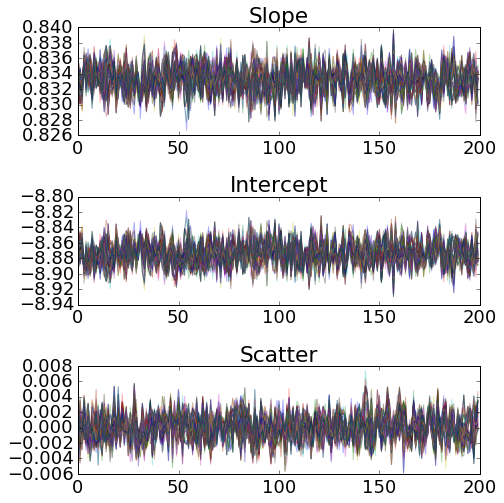

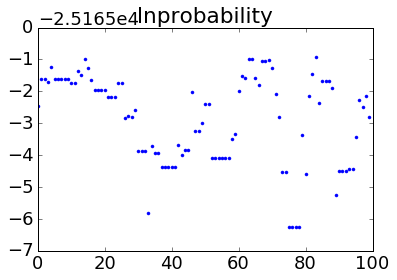

In [15]:
## Diagnostic plots
f1,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(7,7))
ax1.plot(sampler.chain[:,200:,0],alpha=0.3)
ax1.set_title('Slope')
ax2.plot(sampler.chain[:,200:,1],alpha=0.3)
ax2.set_title('Intercept')
ax3.plot(sampler.chain[:,200:,2],alpha=0.3)
ax3.set_title('Scatter')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

f2,ax3=plt.subplots(1,1)
ax3.plot(sampler.lnprobability[0,200:],'.')
ax3.set_title('lnprobability')

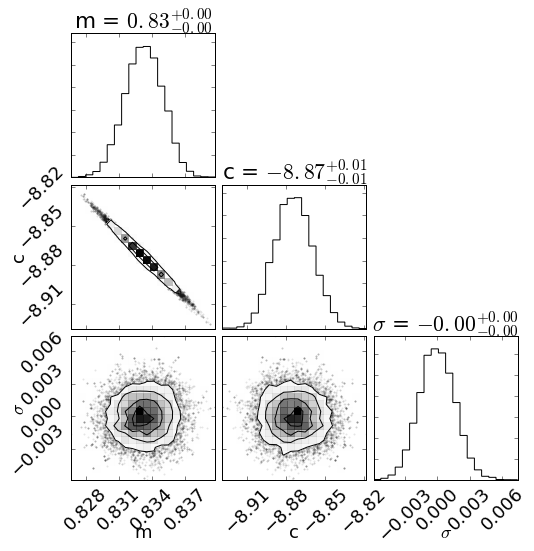

In [16]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
crnr_fig = corner.corner(samples,labels=('m','c',r'$\sigma$'),show_titles=True)

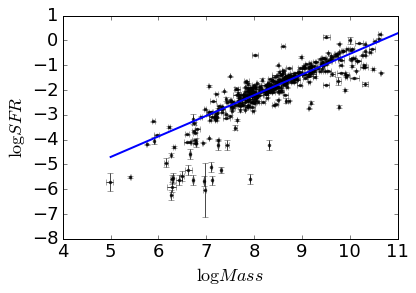

In [18]:
slope = np.percentile(sampler.flatchain[100:,0],50)
intercept = np.percentile(sampler.flatchain[100:,1],50)

fakemass = np.linspace(5,11,100)
fakesfr = slope*fakemass + intercept

fig,ax = plt.subplots(1,1)
ax.errorbar(mass,sfr,xerr=merr,yerr=serr,fmt='.k',alpha=0.7)
ax.set_xlabel(r'$\log{Mass}$')
ax.set_ylabel(r'$\log{SFR}$')
ax.plot(fakemass,fakesfr,'b',linewidth=2)

## Fitting a quadratic
### Note: This needs a better likelihood function!

The above plot clearly has points at the low mass range that do not fit the straight line. Will fitting a quadratic do a better job?

I have reason to believe that it could be quadratic since that the low mass end star formation will be supressed both due to lack of hydrogen gas and due to smaller inflows and retention of pristine gas.

In [ ]:
def lnP(theta,mass,mass_err,sfr,sfr_err):
    """ theta= (k,m,c) """
    mass_fit = np.random.normal(loc=mass,scale=np.absolute(mass_err))
    sfr_fit = theta[0]*(mass_fit)**2 + theta[1]*(mass_fit) + theta[2]
    prob = norm.logpdf(sfr,loc=sfr_fit,scale=np.absolute(sfr_err))
    return np.sum(prob)

ndim,nwalkers = 3,200
theta0 = np.array([np.random.rand(ndim) for i in range(nwalkers)])
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(mass,merr,sfr,serr))
sampler.run_mcmc(theta0,300)

In [ ]:
## Diagnostic plots
f1,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(5,12))
ax1.plot(sampler.chain[:,100:,0],alpha=0.3)
ax1.set_title('Squared term')
ax2.plot(sampler.chain[:,100:,1],alpha=0.3)
ax2.set_title('Linear term')
ax3.plot(sampler.chain[:,100:,2],alpha=0.3)
ax3.set_title('Constant')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

f2,ax4=plt.subplots(1,1)
ax4.plot(sampler.lnprobability[0,100:])

In [ ]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
crnr2 = corner.corner(samples,labels=('a','b','c'),show_titles=True)

In [ ]:
a = np.percentile(sampler.flatchain[:,0],50)
b = np.percentile(sampler.flatchain[:,1],50)
c = np.percentile(sampler.flatchain[:,2],50)

fakemass = np.linspace(4,11,100)
fakesfr = a*(fakemass**2) + b*fakemass + c

fig,ax = plt.subplots(1,1)
ax.errorbar(mass,sfr,xerr=merr,yerr=serr,fmt='.')
ax.set_xlabel(r'$\log{Mass}$')
ax.set_ylabel(r'$\log{SFR}$')
ax.plot(fakemass,fakesfr,'r')

The quadratic fit looks only slightly better than the straight line fit.

# Fitting Mass- Metallicity Relationship

In [19]:
def metallicity(bmag,dist,N):
    M = bmag+5-5*np.log10(dist*1e6)
    Merr = np.random.normal(loc=0,scale=0.1,size=np.size(dist))
    Mb = M+Merr

    Z = 6.27+(-0.11)*M

    Zerr = np.sqrt((0.21)**2 + ((0.01/0.11)**2+(Merr/M)**2)*(0.11*M)**2) 
    +np.random.normal(loc=0,scale=0.15,size=np.size(dist))

    return Z,Zerr

In [21]:
dist,bmag,fuv,fuv_err = np.loadtxt('ps5.data',comments='#',usecols=(7,8,11,12)).T
mask = np.where((bmag!=99.99)&(fuv!=99.99))
N = np.size(mask)
dist, bmag, fuv, fuv_err = dist[mask], bmag[mask], fuv[mask], fuv_err[mask]

err_mask = np.where(fuv_err==99.99)
fuv_err[err_mask]= 0.5

met,merr = metallicity(bmag,dist,N)
sfr,serr = gen_sfr(fuv,fuv_err,dist,N)

In [20]:
def lnP(theta,met,met_err,sfr,sfr_err):
    chi2 = 0.5*(sfr-theta[1]-theta[0]*met)**2/(sfr_err**2 + (theta[0]*met_err)**2)
    s = 0.5*np.log(sfr_err**2+(theta[0]*met_err)**2+theta[2]**2)
    return -np.sum(chi2+s)

In [22]:
ndim,nwalkers = 3,200
theta0 = np.array([np.random.rand(ndim) for i in range(nwalkers)])

sampler = emcee.EnsembleSampler(nwalkers,ndim,lnP,args=(met,merr,sfr,serr))
sampler.run_mcmc(theta0,300)

(array([[  2.36994914e+03,  -6.65367553e+03,   2.93004228e+02],
        [  2.89508748e+00,  -2.50427056e+01,  -5.46789664e-02],
        [ -7.23021856e+00,   5.51012174e+01,  -1.76111068e-01],
        [ -6.83951160e+00,   5.16609490e+01,  -1.26511263e-02],
        [ -6.44953212e+00,   4.87712747e+01,   1.24741546e-01],
        [ -7.03068443e+00,   5.34643029e+01,   7.75997908e-02],
        [  2.79786164e+00,  -2.42227914e+01,   7.38856885e-02],
        [  2.72585930e+00,  -2.36522785e+01,   1.53399903e-02],
        [ -7.44919339e+00,   5.67728418e+01,  -2.45859295e-01],
        [  2.78468292e+00,  -2.42434920e+01,  -3.67293761e-02],
        [ -7.03786849e+00,   5.33963803e+01,   8.11287355e-02],
        [  2.93045339e+00,  -2.53328482e+01,   4.87025993e-02],
        [  2.89909209e+00,  -2.51196478e+01,  -5.40533107e-02],
        [  2.83023784e+00,  -2.44877442e+01,  -3.14042643e-02],
        [  2.73067054e+00,  -2.37341934e+01,  -5.71985467e-02],
        [  2.96325723e+00,  -2.55853750e

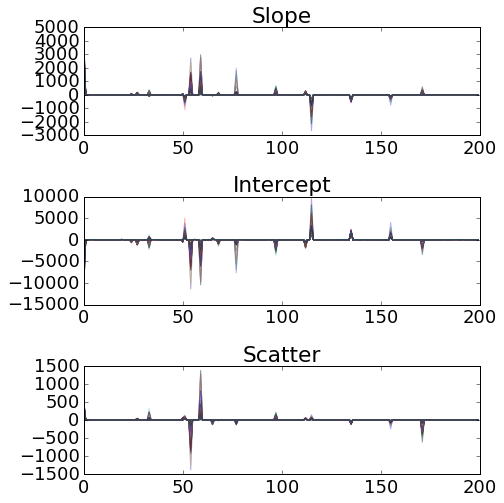

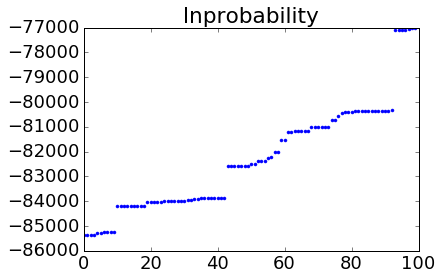

In [23]:
## Diagnostic plots
f1,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(7,7))
ax1.plot(sampler.chain[:,200:,0],alpha=0.3)
ax1.set_title('Slope')
ax2.plot(sampler.chain[:,200:,1],alpha=0.3)
ax2.set_title('Intercept')
ax3.plot(sampler.chain[:,200:,2],alpha=0.3)
ax3.set_title('Scatter')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

f2,ax3=plt.subplots(1,1)
ax3.plot(sampler.lnprobability[0,200:],'.')
ax3.set_title('lnprobability')

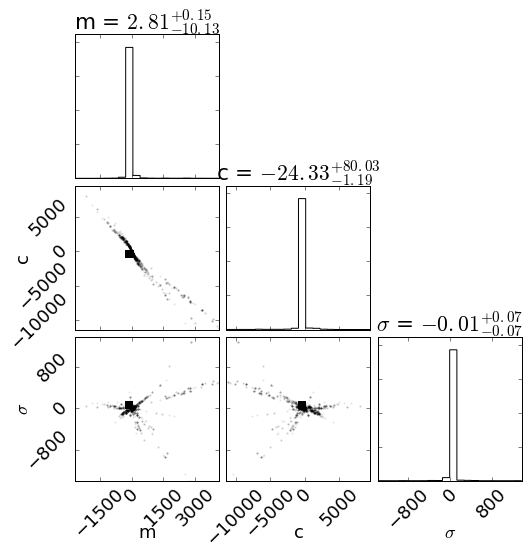

In [24]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
crnr2 = corner.corner(samples,labels=('m','c',r'$\sigma$'),show_titles=True)

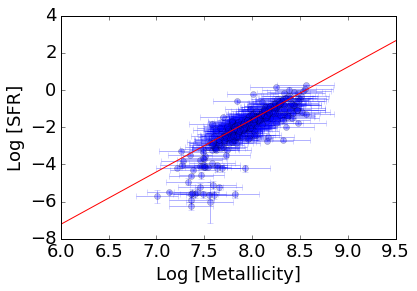

In [28]:
slope = np.percentile(sampler.flatchain[:,0],50)
intercept = np.percentile(sampler.flatchain[:,1],50)

fakemet = np.linspace(6,9.5,100)
fakesfr = slope*fakemet + intercept

fig,ax = plt.subplots(1,1)
ax.errorbar(met,sfr,xerr=merr,yerr=serr,fmt='o',alpha=0.3)
ax.set_xlabel(r'Log [Metallicity]')
ax.set_ylabel(r'Log [SFR]')
ax.plot(fakemet,fakesfr,'r')

## SFR-Metallicity

It appears like the SFR-metallicity relation is more quadratic than linear, which is probably why the Markov Chain for a linear fit is not converging very well. For fitting a quadratic I need a better likelihood function than adding a squared term to the above equation- which I would have been able to find out if I had started working on the problem earlier. 

##### TODO: Find the likelihood function for fitting a quadratic

# Caveats

### SFR-Mass relation

Assumptions:

1. The mass was derived from the B-band magnitudes by assuming a constant star formation history. Evidently, the B-band magnitude obtained for different star formation histories is very different. Hence this assumption could affect my interpretation of the mass-sfr relation, though it should be remembered that all these galaxies are currently star forming.

2. The SFR was obtained from UV luminosities without accounting for dust correction. With a simple Calzetti law, I verified that Kennicutt& Evans(2012) relation remains roughly the same (order of magnitude) even with dust correction but with IR data this can be better accounted for.

3. The low mass end has a lower SFR than estimated by my linear fit- this might be due to quenched star formation which I did not account for. It would be worthwhile to fit a quadratic or another functional form to this data to see if the quenching can be accounted for.